In [2]:
cd ..

m:\OneDrive\Projects\federated_imputation


In [10]:
from src.modules.data_preprocessing import load_data
from sklearn.model_selection import train_test_split

In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from dython.nominal import correlation_ratio
import itertools as it

### Classifiers

In [486]:
def eval_LR(X_train, y_train, X_test, y_test, seed = 21):
    model = LogisticRegression(random_state=seed, solver='liblinear', multi_class='ovr', max_iter=1000)
    grid = {'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}
    clf = GridSearchCV(model, grid, cv= StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

def eval_svm(X_train, y_train, X_test, y_test, seed = 21):
    model = SVC(random_state=seed, kernel='rbf', probability=True)
    grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001]}
    clf = GridSearchCV(model, grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

def eval_rf(X_train, y_train, X_test, y_test, seed = 21):
    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    grid = {'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [2, 3, 5, 10, 20]}
    clf = GridSearchCV(model, grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

## Simulate Missing Data

In [315]:
from src.missing_data_exploration.sub_modules.ms_simulate_hy import simulate_nan
import missingno
from pyampute.ampute import MultivariateAmputation

### Logistic Hyperimpute

<AxesSubplot: >

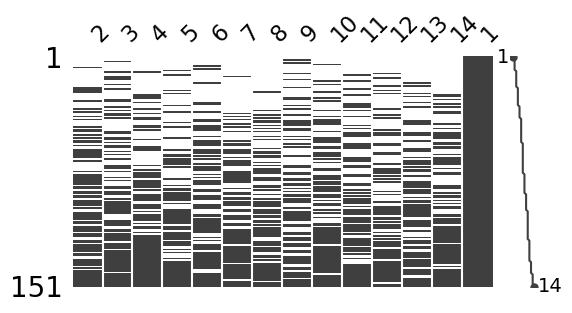

In [474]:
ret = simulate_nan(train_data.values, missing_ratio=0.5, mechanism = 'mary', p_na_cols = 1.0,seed=31)
train_data_ms = ret['train_data_ms']
train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)
missingno.matrix(train_data_ms, sort='ascending', figsize=(6, 3))

### Missing Pattern by Ampute

[{'incomplete_vars': [6, 12, 11, 0, 12, 9, 5, 10, 1, 3, 8, 2, 7], 'mechanism': 'MAR', 'score_to_probability_func': 'sigmoid-tail'}]
(151, 13) (151,)


<AxesSubplot: >

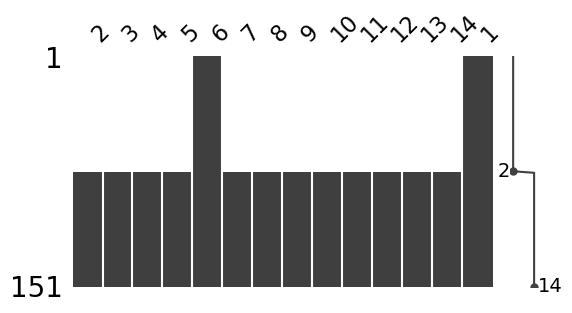

In [445]:
mechs = ["MAR"]
funcs = ["sigmoid-right", "sigmoid-mid", "sigmoid-left", "sigmoid-tail"]
func = funcs[3]
incomplete_vars = [[6, 12, 11, 0, 12, 9, 5, 10, 1, 3, 8, 2, 7]]

ret = [
    {"incomplete_vars": icp_vars, "mechanism": mechs[0], "score_to_probability_func": func} for icp_vars in incomplete_vars
]
print(ret)
ma = MultivariateAmputation(
    prop = 0.5,
    patterns = ret,
    seed = seed,
)
X_train_ms = train_data.drop(config['target'], axis=1).values
y_train  = train_data[config['target']].values
X_train_ms = ma.fit_transform(X_train_ms)
print(X_train_ms.shape, y_train.shape)

train_data_ms = pd.DataFrame(np.hstack([X_train_ms, np.expand_dims(y_train, 1)]), columns=train_data.columns)
missingno.matrix(train_data_ms, sort='ascending', figsize=(6, 3))

## Iris

In [ ]:
data, config = load_data('iris')
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
correlation_ret

In [ ]:
X_train = train_data.drop(config['target'], axis=1)
y_train = train_data[config['target']]
X_test = test_data.drop(config['target'], axis=1)
y_test = test_data[config['target']]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

eval_LR(X_train, y_train, X_test, y_test, seed=seed)
eval_svm(X_train, y_train, X_test, y_test, seed=seed)

In [493]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 100):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mcar', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=50, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.9095300834431269(0.03478083420856097) svm 0.9494949494949496(0.021144318168134803)
Iter lr 0.9556433904259993(0.012328211548193425) svm 0.9552042160737816(0.011485899719474777)
missing ratio:  0.2
Simple lr 0.8484848484848483(0.045143192882771556) svm 0.9222661396574441(0.027824390094786423)
Iter lr 0.9503732981993854(0.02694398181849447) svm 0.9530083443126923(0.01712216837032758)
missing ratio:  0.3
Simple lr 0.8115942028985507(0.04369729631561789) svm 0.8919631093544137(0.048801736962983205)
Iter lr 0.9345630215195434(0.03926621510277931) svm 0.9503732981993854(0.03151668883269067)
missing ratio:  0.4
Simple lr 0.7891963109354414(0.024222366680962087) svm 0.849802371541502(0.05936168814792519)
Iter lr 0.8976723759332454(0.06064741799193339) svm 0.9486166007905139(0.039744672276675524)
missing ratio:  0.5
Simple lr 0.782169521299956(0.015749162123004933) svm 0.8102766798418971(0.05438673897378205)
Iter lr 0.856829161176987(0.07079839273214451) svm 0.93

In [495]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 100):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mary', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=50, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.846728151075977(0.04720256071161843) svm 0.9420289855072466(0.03089865454429139)
Iter lr 0.9574000878348705(0.020477019283047466) svm 0.9578392621870885(0.009681777639459202)
missing ratio:  0.2
Simple lr 0.8107158541941151(0.03512845806907547) svm 0.9319279754062364(0.05026580211796047)
Iter lr 0.9134826526130875(0.062257514788473786) svm 0.9644268774703559(0.0167693307791276)
missing ratio:  0.3
Simple lr 0.7979797979797978(0.03672295996551053) svm 0.8792270531400966(0.06497702904819415)
Iter lr 0.84409310496267(0.05562104593408014) svm 0.9437856829161178(0.046349022163499884)
missing ratio:  0.4
Simple lr 0.756258234519104(0.07564005319845757) svm 0.8199385155906894(0.0731221999330508)
Iter lr 0.805445761967501(0.06128331503737341) svm 0.914800175669741(0.06537652724085516)
missing ratio:  0.5
Simple lr 0.6965305226174792(0.09412275865125194) svm 0.7619675010979358(0.06491466391533379)
Iter lr 0.7716293368467281(0.07873846229605612) svm 0.859025032938

## Telugu Vowel

In [496]:
data, config = load_data('telugu_tabular')
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
correlation_ret

Index(['2', '3', '4', '1'], dtype='object')
{'target': '1', 'important_features_idx': [0, 1, 2], 'features_idx': [0, 1, 2], 'num_cols': 3, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(740, 4) (131, 4)


1    1.000000
3    0.932286
2    0.866065
4    0.604345
dtype: float64

In [504]:
X_train = train_data.drop(config['target'], axis=1)
y_train = train_data[config['target']]
X_test = test_data.drop(config['target'], axis=1)
y_test = test_data[config['target']]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print(eval_LR(X_train, y_train, X_test, y_test, seed=seed))
print(eval_svm(X_train, y_train, X_test, y_test, seed=seed))

(740, 3) (740,) (131, 3) (131,)
0.816793893129771
0.8625954198473282


In [499]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 50):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mcar', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=30, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.7879732045489951(0.01177201152036926) svm 0.8604143947655397(0.01252903521600444)
Iter lr 0.7899984421249417(0.010918470458286488) svm 0.8627512073531703(0.008654272885079403)
missing ratio:  0.2
Simple lr 0.7825206418445242(0.01058667518805546) svm 0.8359557563483407(0.011345780623793789)
Iter lr 0.772706028976476(0.014323981322913324) svm 0.8532481694968065(0.012927547241454895)
missing ratio:  0.3
Simple lr 0.7686555538245832(0.015047815100225246) svm 0.8230253933634523(0.010648392267103948)
Iter lr 0.7618009035675338(0.01696296318905273) svm 0.8398504439943917(0.017138041834158662)
missing ratio:  0.4
Simple lr 0.76226826608506(0.015422176252705488) svm 0.8153918055771928(0.010759493160823816)
Iter lr 0.7551020408163265(0.020566311052449597) svm 0.8323726437139741(0.019011182813642988)
missing ratio:  0.5
Simple lr 0.7398348652438074(0.02091037449517062) svm 0.8007477800280417(0.015286239690962579)
Iter lr 0.7429506153606479(0.02549970707662892) svm 

In [501]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 50):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mary', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=30, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.7815859168094719(0.011418278362242532) svm 0.8532481694968064(0.009539997440345773)
Iter lr 0.7937373422651504(0.006631499191086711) svm 0.8540271070260165(0.007497248428425602)
missing ratio:  0.2
Simple lr 0.7543231032871164(0.009835609358258038) svm 0.8314379186789217(0.012127434463952967)
Iter lr 0.7572830658981151(0.012901237334639899) svm 0.8454587942047049(0.009321249603771037)
missing ratio:  0.3
Simple lr 0.7217635145661319(0.021373001136745527) svm 0.8149244430596666(0.010962836632347216)
Iter lr 0.7029132263592459(0.034548316258586835) svm 0.8076024302850912(0.02202617175225544)
missing ratio:  0.4
Simple lr 0.663498987381212(0.03536479324401626) svm 0.7736407540115284(0.03826288301486494)
Iter lr 0.6278236485433868(0.029565989694222847) svm 0.757438853403957(0.026365395747084255)
missing ratio:  0.5
Simple lr 0.6103754478890793(0.025386194303468886) svm 0.6784545879420468(0.053080806375634344)
Iter lr 0.5949524848107183(0.01208533563060882) s

## Wine

In [508]:
data, config = load_data('wine')
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
correlation_ret

Index(['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
       '1'],
      dtype='object')
{'target': '1', 'important_features_idx': [6, 12, 11, 0, 9, 10, 5, 1, 3, 8, 7, 2, 4], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'num_cols': 13, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(151, 14) (27, 14)


1     1.000000
8     0.853098
14    0.838935
13    0.827438
2     0.779024
11    0.761353
12    0.732522
7     0.719163
3     0.544857
5     0.538689
10    0.506986
9     0.489519
4     0.363394
6     0.352680
dtype: float64

In [509]:
X_train = train_data.drop(config['target'], axis=1)
y_train = train_data[config['target']]
X_test = test_data.drop(config['target'], axis=1)
y_test = test_data[config['target']]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print(eval_LR(X_train, y_train, X_test, y_test, seed=seed))
print(eval_svm(X_train, y_train, X_test, y_test, seed=seed))

(151, 13) (151,) (27, 13) (27,)
0.9259259259259259
0.9629629629629629


In [510]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 50):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mcar', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=30, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.9538926681783824(0.021854621760848) svm 0.9538926681783824(0.017597047206081334)
Iter lr 0.9629629629629629(0.021164021164021166) svm 0.9523809523809523(0.0167316278315787)
missing ratio:  0.2
Simple lr 0.9516250944822371(0.020083643621445817) svm 0.9561602418745275(0.0178228663984151)
Iter lr 0.9478458049886621(0.023565317109780628) svm 0.948601662887377(0.02344378294674348)
missing ratio:  0.3
Simple lr 0.9569160997732425(0.013689168765135908) svm 0.9561602418745275(0.016176065426328552)
Iter lr 0.9395313681027967(0.029642738550457393) svm 0.9538926681783824(0.015926914214441003)
missing ratio:  0.4
Simple lr 0.9554043839758124(0.018297382368722893) svm 0.9538926681783824(0.017597047206081334)
Iter lr 0.9478458049886621(0.026894099583759924) svm 0.9561602418745275(0.019329874304677874)
missing ratio:  0.5
Simple lr 0.9546485260770974(0.017169790917007613) svm 0.9402872260015116(0.02221759403884967)
Iter lr 0.9334845049130763(0.036641571106699376) svm 0

In [511]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 50):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mary', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=30, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.9508692365835222(0.018911558583819783) svm 0.9591836734693877(0.011211184409819577)
Iter lr 0.9523809523809523(0.022447834323382446) svm 0.9561602418745275(0.014341395284210313)
missing ratio:  0.2
Simple lr 0.9523809523809523(0.0167316278315787) svm 0.9546485260770974(0.015453551247362692)
Iter lr 0.9508692365835224(0.020338056004646558) svm 0.9561602418745275(0.0178228663984151)
missing ratio:  0.3
Simple lr 0.9561602418745275(0.01617606542632855) svm 0.9546485260770974(0.017169790917007613)
Iter lr 0.9523809523809523(0.02244783432338245) svm 0.9599395313681028(0.01260266969050117)
missing ratio:  0.4
Simple lr 0.9538926681783824(0.015926914214441003) svm 0.9372637944066515(0.029176506523989072)
Iter lr 0.945578231292517(0.024931855634876238) svm 0.9501133786848072(0.02543099598074182)
missing ratio:  0.5
Simple lr 0.9387755102040817(0.028543019786091) svm 0.9115646258503399(0.051741772003400854)
Iter lr 0.929705215419501(0.02921564337125878) svm 0.925

## Pima Diabetes

In [513]:
data, config = load_data('pima_diabetes')
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
correlation_ret

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
{'target': 'Outcome', 'important_features_idx': [1, 5, 7, 0, 6, 4], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7], 'num_cols': 8, 'task_type': 'classification', 'clf_type': 'binary-class', 'data_type': 'tabular'}
(652, 9) (116, 9)


Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
dtype: float64

In [514]:
X_train = train_data.drop(config['target'], axis=1)
y_train = train_data[config['target']]
X_test = test_data.drop(config['target'], axis=1)
y_test = test_data[config['target']]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print(eval_LR(X_train, y_train, X_test, y_test, seed=seed))
print(eval_svm(X_train, y_train, X_test, y_test, seed=seed))

(652, 8) (652,) (116, 8) (116,)
0.75
0.7586206896551724


In [515]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 50):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mcar', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=30, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.7447220267417312(0.00831920507919555) svm 0.7361013370865588(0.01112694461705974)
Iter lr 0.7484166080225193(0.008651154717202134) svm 0.7436664320900774(0.01603593084462468)
missing ratio:  0.2
Simple lr 0.739795918367347(0.010106549342959242) svm 0.7315270935960589(0.013377808486699772)
Iter lr 0.7491203377902885(0.009090788657821107) svm 0.7385643912737511(0.015122004888771499)
missing ratio:  0.3
Simple lr 0.7396199859254046(0.010001879242471428) svm 0.7283603096410979(0.01558963963186187)
Iter lr 0.7473610133708656(0.016356987050203314) svm 0.7355735397607319(0.017794416338480338)
missing ratio:  0.4
Simple lr 0.7352216748768473(0.010303694908055123) svm 0.7239619985925405(0.015722101064566427)
Iter lr 0.7369809992962704(0.017686242592346503) svm 0.7253694581280788(0.020680856679490968)
missing ratio:  0.5
Simple lr 0.7343420126671357(0.011770393162334782) svm 0.7246657283603097(0.017011857499836133)
Iter lr 0.7301196340605207(0.03910768848451415) s

In [516]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 50):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mary', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=30, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.7417311752287121(0.01073043679238347) svm 0.729064039408867(0.015083064918615625)
Iter lr 0.7482406755805769(0.010591074555448563) svm 0.7415552427867697(0.016103345420828866)
missing ratio:  0.2
Simple lr 0.7406755805770585(0.014131657725561722) svm 0.6963406052076002(0.027331318612533326)
Iter lr 0.7477128782547502(0.014548240738513735) svm 0.7283603096410979(0.021196756483925442)
missing ratio:  0.3
Simple lr 0.7236101337086557(0.03489410541536435) svm 0.6608022519352569(0.02745786363329154)
Iter lr 0.7385643912737511(0.014715357963635807) svm 0.6945812807881772(0.02698140677365351)
missing ratio:  0.4
Simple lr 0.6736453201970443(0.03478927805868358) svm 0.6572836030964111(0.02035044861494899)
Iter lr 0.7098874032371569(0.035246254660495864) svm 0.6796270232230823(0.01918551144294945)
missing ratio:  0.5
Simple lr 0.6669598874032371(0.027465753338334325) svm 0.6511259676284307(0.014685880897050807)
Iter lr 0.6616819141449682(0.016662576344196458) svm

## Red

In [528]:
data, config = load_data('red')
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
correlation_ret

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
{'target': 'quality', 'important_features_idx': [10, 1, 6, 9, 2, 7], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'num_cols': 11, 'task_type': 'classification', 'clf_type': 'binary-class', 'data_type': 'tabular'}
(1359, 12) (240, 12)


quality                 1.000000
alcohol                 0.516398
volatile acidity        0.400631
total sulfur dioxide    0.272119
sulphates               0.255621
citric acid             0.241260
density                 0.200875
fixed acidity           0.139067
chlorides               0.136353
free sulfur dioxide     0.121255
pH                      0.115950
residual sugar          0.057405
dtype: float64

In [529]:
X_train = train_data.drop(config['target'], axis=1)
y_train = train_data[config['target']]
X_test = test_data.drop(config['target'], axis=1)
y_test = test_data[config['target']]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print(eval_LR(X_train, y_train, X_test, y_test, seed=seed))
print(eval_rf(X_train, y_train, X_test, y_test, seed=seed))
#print(eval_svm(X_train, y_train, X_test, y_test, seed=seed))

(1359, 11) (1359,) (240, 11) (240,)
0.5625
0.7125


In [531]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 20):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mcar', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=30, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_rf(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_rf(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) rf {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) rf {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.5675438596491229(0.0110305055613678) rf 0.6995614035087719(0.013029342787292059)
Iter lr 0.5662280701754385(0.009057840538624278) rf 0.7041666666666666(0.015354009705451152)
missing ratio:  0.2
Simple lr 0.5611842105263157(0.011151914153588703) rf 0.6787280701754387(0.013029342787292056)
Iter lr 0.5635964912280702(0.009919458664823378) rf 0.6758771929824562(0.01619840816896436)
missing ratio:  0.3
Simple lr 0.557236842105263(0.013775700679420553) rf 0.6407894736842106(0.020348702999407095)
Iter lr 0.5660087719298245(0.016124014425133153) rf 0.643859649122807(0.019930820644739927)
missing ratio:  0.4
Simple lr 0.5506578947368421(0.013603563525676165) rf 0.6239035087719299(0.019442245841492546)
Iter lr 0.5462719298245614(0.01615976616398294) rf 0.6127192982456141(0.024500629699007567)
missing ratio:  0.5
Simple lr 0.5469298245614035(0.012955311831352585) rf 0.6008771929824562(0.02007746999692385)
Iter lr 0.5524122807017544(0.013128622409733136) rf 0.598903

In [532]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 20):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mary', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=30, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_rf(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_rf(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) rf {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) rf {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.5592105263157896(0.008396574438191508) rf 0.6642543859649122(0.010925367286913288)
Iter lr 0.5675438596491228(0.0075967140682845526) rf 0.6813596491228071(0.01860290356179692)
missing ratio:  0.2
Simple lr 0.5565789473684211(0.0073194382755607966) rf 0.6243421052631579(0.013536227510535931)
Iter lr 0.5614035087719299(0.005547855544155031) rf 0.6510964912280702(0.018179282259704128)
missing ratio:  0.3
Simple lr 0.5611842105263157(0.00449427665173665) rf 0.5686403508771929(0.016521761580559086)
Iter lr 0.5655701754385966(0.008205389006083204) rf 0.6375(0.024705872114925715)
missing ratio:  0.4
Simple lr 0.5644736842105262(0.0056338739380110015) rf 0.4807017543859649(0.018545942554268394)
Iter lr 0.5660087719298247(0.008683767488255842) rf 0.6182017543859648(0.0157772857443903)
missing ratio:  0.5
Simple lr 0.5668859649122806(0.0043749862594868434) rf 0.4302631578947368(0.010969297368771759)
Iter lr 0.5666666666666665(0.00926778360048921) rf 0.578289473684

## Wine quality

In [533]:
data, config = load_data('wine_quality_all')
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
correlation_ret

1    3915
0    2384
2     198
Name: quality, dtype: int64
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type', 'quality'],
      dtype='object')
{'target': 'quality', 'important_features_idx': [10, 7, 1, 4, 11], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'num_cols': 12, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(5522, 13) (975, 13)


quality                 1.000000
alcohol                 0.414366
density                 0.285245
volatile acidity        0.267544
chlorides               0.189512
type                    0.126314
fixed acidity           0.078980
citric acid             0.076211
free sulfur dioxide     0.056267
total sulfur dioxide    0.049069
sulphates               0.045999
residual sugar          0.032498
pH                      0.019510
dtype: float64

In [534]:
X_train = train_data.drop(config['target'], axis=1)
y_train = train_data[config['target']]
X_test = test_data.drop(config['target'], axis=1)
y_test = test_data[config['target']]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print(eval_LR(X_train, y_train, X_test, y_test, seed=seed))
#print(eval_rf(X_train, y_train, X_test, y_test, seed=seed))
print(eval_svm(X_train, y_train, X_test, y_test, seed=seed))

(5522, 12) (5522,) (975, 12) (975,)
0.718974358974359
0.8112820512820513


In [535]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 20):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mcar', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=30, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.7149257759784075(0.002410484595062464) svm 0.7958434547908232(0.00469976763501839)
Iter lr 0.7200000000000001(0.0022072926639957876) svm 0.801025641025641(0.006063210183902388)
missing ratio:  0.2
Simple lr 0.7088259109311741(0.0036436247299727244) svm 0.7839676113360323(0.005081684010045804)
Iter lr 0.7217273954116059(0.00182421001335663) svm 0.7889338731443994(0.005139840483095324)
missing ratio:  0.3
Simple lr 0.7069365721997302(0.0034395751302724055) svm 0.7695006747638328(0.009292593116082841)
Iter lr 0.7173549257759784(0.005137005021698385) svm 0.7726315789473684(0.006322936772727168)
missing ratio:  0.4
Simple lr 0.7037516869095817(0.005688799374979853) svm 0.7559514170040486(0.006983828486079537)
Iter lr 0.7158434547908231(0.012009310132631033) svm 0.7540620782726046(0.007102568077041189)
missing ratio:  0.5
Simple lr 0.7056950067476383(0.0031476123588908642) svm 0.7390013495276652(0.006951207275220605)
Iter lr 0.7128205128205128(0.00999394259253

In [536]:
import warnings
warnings.filterwarnings("ignore")
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for missing_ratio in missing_ratios:
    print("missing ratio: ", missing_ratio)
    clf_seed = 21
    simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
    for seed in range(1, 30):
        #print("===========================================================================================")
        ret = simulate_nan(train_data.values, missing_ratio=missing_ratio, mechanism = 'mary', p_na_cols = 1.0, seed=seed)
        train_data_ms = ret['train_data_ms']
        train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)

        X_train_ms = train_data_ms.drop(config['target'], axis=1).values
        y_train = train_data_ms[config['target']].values
        X_test = test_data.drop(config['target'], axis=1).values
        y_test = test_data[config['target']].values
        #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

        X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
        min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
        X_train_imp_iter = IterativeImputer(
            random_state=seed, max_iter=30, min_value=min_values, max_value=max_values
        ).fit_transform(X_train_ms)

        #print("Simple Imputer")
        score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_lr.append(score)
        score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
        simple_svm.append(score)
        #print("Iterative")
        score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_lr.append(score)
        score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
        iter_svm.append(score)
    print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
    print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

missing ratio:  0.1
Simple lr 0.7166755083996466(0.0024487610076907207) svm 0.763289124668435(0.005287563314880493)
Iter lr 0.7203536693191867(0.0020205633042738418) svm 0.7893899204244031(0.00362644731773187)
missing ratio:  0.2
Simple lr 0.7088947833775419(0.0031070609556990187) svm 0.6840318302387266(0.006887749716416518)
Iter lr 0.7192572944297082(0.003151429801583811) svm 0.7642086648983202(0.005684072248691296)
missing ratio:  0.3
Simple lr 0.7047214854111407(0.0025742656601347967) svm 0.5413616268788682(0.011395837947669008)
Iter lr 0.7154022988505747(0.004716416078704056) svm 0.7338638373121132(0.007855599867040425)
missing ratio:  0.4
Simple lr 0.7023165340406718(0.0029708222811671054) svm 0.4142882404951371(0.007912239547726645)
Iter lr 0.7113351016799294(0.004800010631957144) svm 0.6826171529619803(0.008229787026500283)
missing ratio:  0.5
Simple lr 0.698815207780725(0.004060579708656478) svm 0.3714588859416446(0.0018281659392848915)
Iter lr 0.7082935455349247(0.005704281566